# Support Vector Machines

In [13]:
import pandas as pd
from sklearn import svm
import sklearn.model_selection
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from statistics import mean
import numpy
from scipy import stats
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, mutual_info_score, matthews_corrcoef

## Understanding Support Vector Machines
Support vector machines use the theoretical upperbound of the generalisation error to create a hyperplane between the 2 classifications. The most important properties for generalisation error are:
* The upper bound is minimised by maximising the margin or the minimal distance between the hyperplane of the two classes and closest datapoints in each category to that hyperplane.
* The bound does not depend on dimensionality of the space.

Generally SVMs are considered very robust and work very well on an intuitive level. However, there are times when the datapoints are not linearly seperable and as such, a kernal trick is reuqired to separate the data into a space that allows for linear separation. The hyperplanes are defined by the set of points whose dot product with one of a set of vetors is a constant. Here the set of vectors are chosen as orthogonal to minimise the size of the set. 

An extension of Support Vector Machines is Support Vector Clustering (SVC), which uses similar kernel functions but with the goal of finding the smallest sphere that encompasses the selected data, which is then used as the cluster boundry. This is what we will be using here. 

In [3]:
df = pd.read_csv('../data/processed/test_train.csv').drop(columns = ['Unnamed: 0'])

## Training the models
The main structure of our testing and training is the separation of the data into 4 categories, one for each attack type and then the normal data randomly distributed between the 4. For each of these test-train sets we do a 10-fold model selection on the training data. This is done to provide us a higher likelihood to return a good model for this category. We then choose the model that provides the highest score when compared with the actual data. We then choose this model to represent the catagory. This is repeated for each of the 4 categories. After this, each of the 4 selected models are put forward for a final selection process to see which model does best on average across the 4 test datasets. This model is then selected as the best SVM and is forwarded for final evaluation against the other model types. 

In [4]:
kf = KFold(n_splits=10, random_state=57, shuffle=True)
parameters = []
for i in range(1,5):
    print(i)
    #for each category of attack, split the data into the required test and train sections
    dftrain = df.loc[df['test'] != i]
    score_1 = 0
    parameters_1 = []
    for split in kf.split(dftrain):
        print("round")
        #on the training data, do a 10-fold 
        train = dftrain.iloc[split[0]]
        test = dftrain.iloc[split[1]]
        xtrain = scale(train.iloc[:,:-2])
        xtest = scale(test.iloc[:,:-2])
        ytrain = train.iloc[:,-2]
        ytest = test.iloc[:,-2]
        #fit one of the k-folds 
        model_1 = svm.SVC(cache_size = 1000)
        instance = model_1.fit(xtrain,ytrain)
        temp_score_1 = instance.score(xtest,ytest)
        #if the new model works better than previous ones then save its parameters
        if temp_score_1 > score_1:
            score_1 = temp_score_1
            parameters_1 = instance
    #list of the best models from each of the 4 main training data sets
    parameters.append(parameters_1)
score = 0
best_params = []
#For each model test how it does in looking at new attacks
for j in range(4):
    print("j - ", j)
    instance = parameters[j]  
    scores = []
    for i in range(1,5):
        print(i)
        x = scale(df.loc[df['test'] == i].iloc[:,:-2])
        y = df.loc[df['test'] == i].iloc[:,-2]
        scores.append(instance.score(x,y))
        print(scores)
    if mean(scores) > score:
        score = mean(scores)
        best_params = parameters[j]
print(score)

1
round
round
round
round
round
round
round
round
round
round
2
round
round
round
round
round
round
round
round
round
round
3
round
round
round
round
round
round
round
round
round
round
4
round
round
round
round
round
round
round
round
round
round
j -  0
1
[0.11771241405680728]
2
[0.11771241405680728, 0.9838315324552409]
3
[0.11771241405680728, 0.9838315324552409, 0.9936425905418154]
4
[0.11771241405680728, 0.9838315324552409, 0.9936425905418154, 0.990124758390441]
j -  1
1
[0.9979342370745526]
2
[0.9979342370745526, 0.09559113494755107]
3
[0.9979342370745526, 0.09559113494755107, 0.05746277839301095]
4
[0.9979342370745526, 0.09559113494755107, 0.05746277839301095, 0.2299771569144263]
j -  2
1
[0.9974027660541523]
2
[0.9974027660541523, 0.12883508163104346]
3
[0.9974027660541523, 0.12883508163104346, 0.07924203273040482]
4
[0.9974027660541523, 0.12883508163104346, 0.07924203273040482, 0.26199261992619927]
j -  3
1
[0.9986124037159684]
2
[0.9986124037159684, 0.09452638220679864]
3
[0.99

## Evaluation
Now that we have trained the data, we need to see how effective the model is at predicting the different types of attacks. To do this we have decided on three different types of evaluation metrics:
* Matthew's Correlation Coefficient (MCC)
* Variation of Information (VI)
* Precision-Recall curve 

#### Matthew's Correlation Coefficient (MCC)
Matthew's Correlation Coefficient is a metric that allows you to compare binary classifiers. The MCC produces a value between -1 and 1. With values near -1, this indicates that the two clusterings almost always put a value in the opposite cluster. With values near 0, this indicates that there is almost no correlation between the two clusterings. With values near 1, this indicates that the two clusterings almost always put a value in the same cluster. Therefore, we are looking for values near 1, although values near -1 would also be very interesting but it would indicate that the model is categorising the normal traffic as malicious and vice versa. 

##### The Equation
The MCC is caluclated using the following $MCC = \frac{TP*TN-FP*FN}{\sqrt{TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$, where TP = True Positives, TN = True Negatives, FP = False Positives, FN = False Negatives. 

##### Advantages
The MCC can be considered to have advantage over the various model evaluation metrics such as accuracy and F1 score as it considers each of the the 4 values in the confusion matrix, and as such provides more information in the produced value and ensuring that we understand the effectiveness of both the categorisation of positive and negative data and not just positive data. 

#### Variation of Information (VI)
Variation of Information is a type of measure similar to mutual information. Mutual information is a notion of average uncertainty about which cluster a datapoint is located in in one clustering given what cluster the datapoint is in the other clustering. The VI of a clustering C and C' is a function that indicates how much 'information' is lost from C when moving to C' and how much information we still have to gain from C'. As such indicates how much overlap the clusters overlap between two clusterings.

##### The Range
The value produced by VI does not lie in a fixed range, rather it has a lower bound of $\frac{2}{n}$ for C $\neq$ C'. It has an upper bound of log(n) or if K $\leq \sqrt{n}$ then it is 2log(K). Where n is the number of data points and K is the number of clusters, so in this case K = 2. 

##### The Equation
The VI is calculated using the following $VI(C,C') = H(C) + H(C') - 2I(C,C')$, where $H(C) = -\sum_{i=1}^{k}P(i)\log_{2}(P(i))$ and $I(C,C')=\sum_{i=1}^{k} \sum_{j=1}^{l}P(i,j)\log_{2}(\frac{P(i,j)}{P(i)P(j)})$ and $P(i,j) = \frac{|C_{i} \cap C'_{j}|}{n}$.

##### Advantages
Due to this being an information-theoretical measure it has does not seem to have the same drawbacks as other clustering comparison metrics such as those based on counting pairs and set overalps. Although this is less researched than such fields. 

#### Precision-Recall Curves
Precision and recall curves are commonly used for evaluating binary classification algorithms. They use the metrics of $Precision = \frac{TP}{TP+FP}$ and $Recall = \frac{TP}{TP+FN}$. Both precision and recall are fairly primitive as it looks at little infromation from the confusion matrix, however this in combination with the MCC can provide insights into the effectiveness of correctly identifying malicious traffic. 

With the plot, would be looking for the line to pass near (1,1). Precision-recall curves are often compared with Reciever Operating Characteristic (ROC) curve, however we have used the former as PR curves are better for looking at imbalanced data. 

In [ ]:
def variation_of_information_score(true_class, model_class):
    return (stats.entropy(numpy.unique(true_class, return_counts=True)[1]) 
            + stats.entropy(numpy.unique(model_class, return_counts=True)[1]) 
            - 2*mutual_info_score(true_class, model_class))

### Test Class 1 (Denial of Service)

MCC:  -0.06226086007225156
Variation of Information:  0.4881098426710313


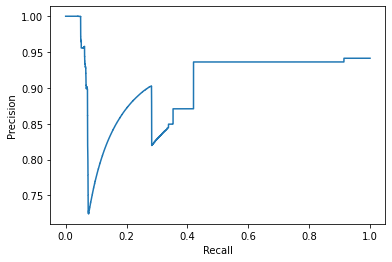

In [47]:
test_1 = scale(df.loc[df['test'] == 1].iloc[:,:-2])
true_class_1 = numpy.array(df[df["test"] == 1].iloc[:, -2]) ^ True
model_class_1 = best_params.predict(test_1) ^ True

precision_1, recall_1, _ = precision_recall_curve(true_class_1, -best_params.decision_function(test_1))
curve_1 = PrecisionRecallDisplay(precision=precision_1, recall=recall_1)
mcc_1 = matthews_corrcoef(true_class_1, model_class_1)
voi_1 = variation_of_information_score(true_class_1, model_class_1)

print(curve_1.plot())
print("MCC: ", mcc_1)
print("Variation of Information: ", voi_1)

#### Analysis
Here we can see that the Matthew's Correlation Coefficient is very near 0, which means that the model is not effective, and that working out whether traffic is normal or not is just as effective as flipping a coin. On top of this, we have that the Variation of Information metric is fairly high. This indicates that there is very little overlap in the clusters between the predicted clustering and actual clustering. On top of this the precision-recall curve shows very poor form. Therefore, overall we can see that for the Denial of Service attacks, this model is very poor at predicting them. 

### Test Class 2 (Remote to Local)

MCC:  0.7933329849020653
Variation of Information:  0.1270781665024057


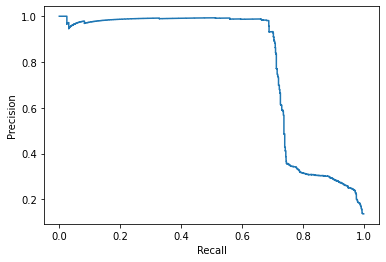

In [48]:
test_2 = scale(df.loc[df['test'] == 2].iloc[:,:-2])
true_class_2 = numpy.array(df[df["test"] == 2].iloc[:, -2]) ^ True
model_class_2 = best_params.predict(test_2) ^ True

precision_2, recall_2, _ = precision_recall_curve(true_class_2, -best_params.decision_function(test_2))
curve_2 = PrecisionRecallDisplay(precision=precision_2, recall=recall_2)
mcc_2 = matthews_corrcoef(true_class_2, model_class_2)
voi_2 = variation_of_information_score(true_class_2, model_class_2)

print(curve_2.plot())
print("MCC: ", mcc_2)
print("Variation of Information: ", voi_2)

#### Analysis
Here we can see the Mathew's Correlation Coefficient is good, which means that the model is good at predicting Remote to Local attacks. The Variation of Information is fairly good, which mean that much of the clusters overlap between the clusters. Finally, the precision-recall curve is resonably good. It shows us that the precision is good but recall is not great. With all of this, it shows that this model is not great at categorising the Remote to Local attacks correctly but what are categorised as attacks are very likely attacks.

### Test Class 3 (User to Root)

MCC:  0.4239538301264504
Variation of Information:  0.04513077199601291


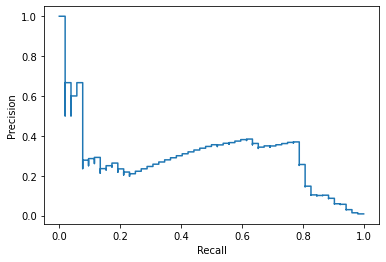

In [49]:
test_3 = scale(df.loc[df['test'] == 3].iloc[:,:-2])
true_class_3 = numpy.array(df[df["test"] == 3].iloc[:, -2]) ^ True
model_class_3 = best_params.predict(test_3) ^ True

precision_3, recall_3, _ = precision_recall_curve(true_class_3, -best_params.decision_function(test_3))
curve_3 = PrecisionRecallDisplay(precision=precision_3, recall=recall_3)
mcc_3 = matthews_corrcoef(true_class_3, model_class_3)
voi_3 = variation_of_information_score(true_class_3, model_class_3)

print(curve_3.plot())
print("MCC: ", mcc_3)
print("Variation of Information: ", voi_3)

#### Analysis
Here we have that the MCC is okay, but not good. The Precision Recall curve is not very good and shows precision being particularly bad and so provides lots of false positives. On top of this, we have that the variation of information is very low, which with the other metrics indicates that there are lots of boundary cases, i.e this model could be improved with some small alterations. This is slightly confusing as VI indicates a very good classification but both other metrics hgihlight a fairly poor performance. Therefore, this model is poor when flagging User to Root, however with some small changes could be improved greatly. 

### Test Class 4 (Probing)

MCC:  0.9596321283494833
Variation of Information:  0.10085076134423798


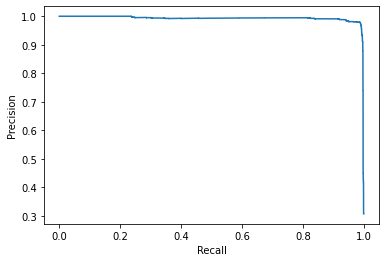

In [50]:
test_4 = scale(df.loc[df['test'] == 4].iloc[:,:-2])
true_class_4 = numpy.array(df[df["test"] == 4].iloc[:, -2]) ^ True
model_class_4 = best_params.predict(test_4) ^ True

precision_4, recall_4, _ = precision_recall_curve(true_class_4, -best_params.decision_function(test_4))
curve_4 = PrecisionRecallDisplay(precision=precision_4, recall=recall_4)
mcc_4 = matthews_corrcoef(true_class_4, model_class_4)
voi_4 = variation_of_information_score(true_class_4, model_class_4)

print(curve_4.plot())
print("MCC: ", mcc_4)
print("Variation of Information: ", voi_4)

#### Analysis
Here the Matthew's Correlation Coefficient is very high, and that the precision-recall curve is very good. Therefore, we have that much of the traffic is correctly categorised. We also have that the Variation of information is fairly low, and so indicating a great overlap in the clusters between the clusterings. Therefore, this model is very effective at identifying probing attacks. 

### Conclusion 
I am reasonably happy with the performance of this model, although it has very poor performance for DoS attacks, it does well with Remote Access attacks and very well with probing attacks. Also, I believe that with some small adjustments, it would be very effective for privilege escelation attacks but it does okay with them in their current state. 

Reference: \
[1] https://en.wikipedia.org/wiki/Matthews_correlation_coefficient \
[2] http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.164.6189&rep=rep1&type=pdf \
[3] https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used \
[4] Learning with Support Vector Machines by Colin Campbell and Yiming Ying